In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



C:\Users\Zhe Hao\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df1 = pd.read_csv("AB_NYC_2019.csv")

In [3]:
df1.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [4]:
df1.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
df1['last_review'] = pd.to_datetime(df1['last_review'],infer_datetime_format=True) 

In [6]:
df1.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Cleaning
last_review and reviews_per_month shouldn't be drop as there could be some airbnb listings which do not have any reviews <br/>
For the dates to be useful, convert it to an ordinal where it can be used as a feature

In [7]:
df1_filtered = df1.drop(['host_name','name' ], axis=1)
df1_filtered.reviews_per_month = df1_filtered.reviews_per_month.fillna(0) #  fill with 0

In [8]:
earliest_date = min(df1_filtered.last_review)
df1_filtered.last_review = df1_filtered.last_review.fillna(earliest_date)
df1_filtered.last_review = df1_filtered.last_review.apply(lambda x : x.toordinal() - earliest_date.toordinal())

In [9]:
df1_filtered.head(3)

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365


# EDA

exploring our variables  <br/>

### 1) Looking at the descriptive statistics and distributions 

In [10]:
df1_filtered.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,2182.321669,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1169.872743,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1823.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,2838.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,3005.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,3024.000000,58.500000,327.000000,365.000000


### Pairwise plot for continuous variables

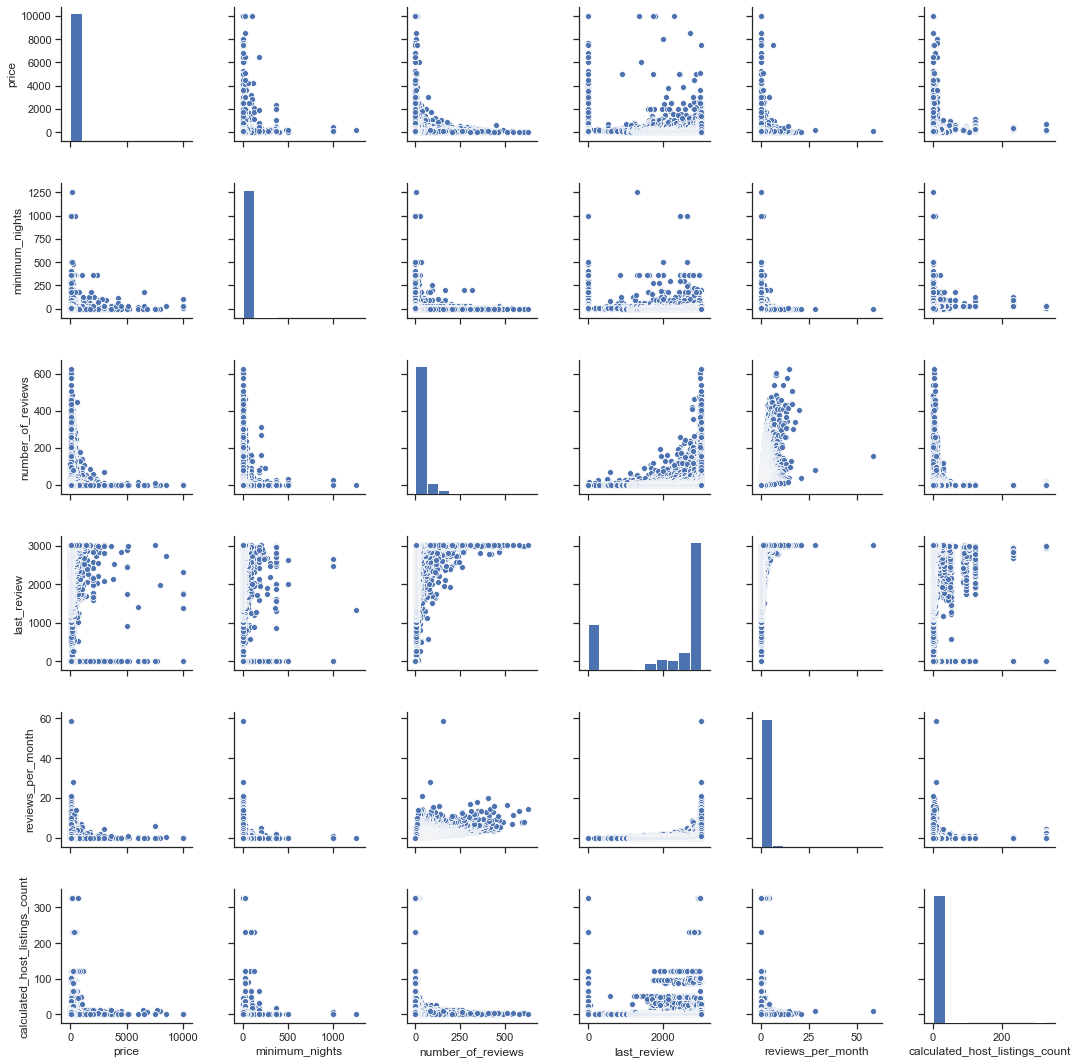

In [11]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df1_filtered, vars= ['price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month' ,'calculated_host_listings_count']);
plt.show()

From the histogram plotted at the diagonals, it can be seen that the data is very skewed. We have to normalize it.

### Apply log normalization 
log(1+x)

In [12]:
variables = ['price','minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count']

for x in variables:
    df1_filtered[x] = np.log1p(df1_filtered[x])

# df1_filtered.price = np.log1p(df1_filtered.price)
# df1_filtered.minimum_nights = np.log1p(df1_filtered.minimum_nights)
# df1_filtered.number_of_reviews = np.log1p(df1_filtered.number_of_reviews)
# df1_filtered

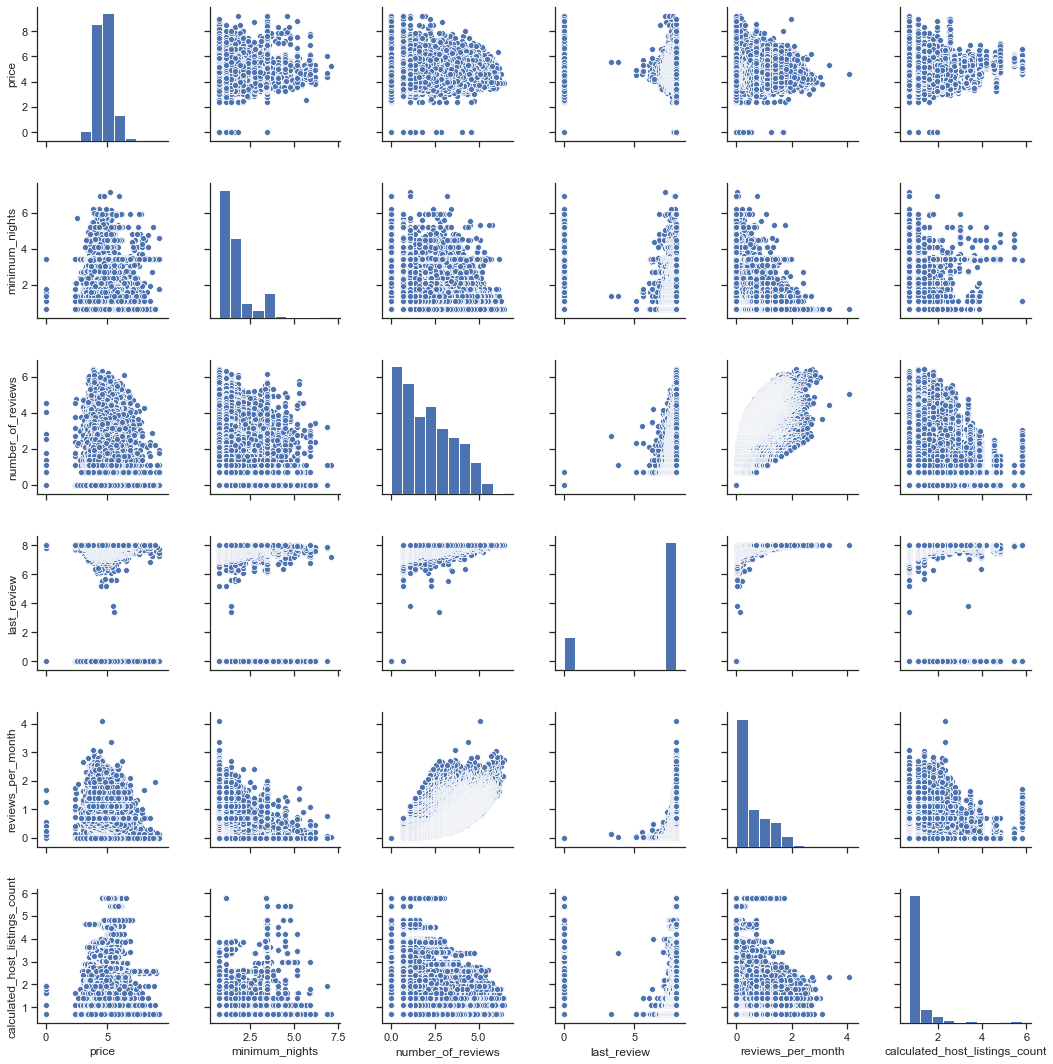

In [13]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df1_filtered, vars= ['price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month' ,'calculated_host_listings_count']);
plt.show()

#### Now the distribution looks better as it is less skewed.
#### There are certain instances where the data is skewed but that cannot be helped as we did not want to remove the outliers as we think that data point could be useful information (e.g. Hosts that have many listings)

C:\Users\Zhe Hao\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


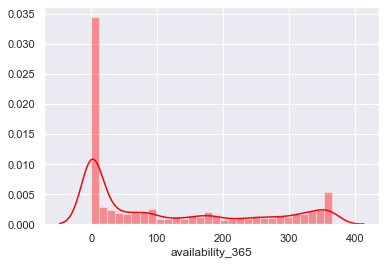

In [14]:
sns.set()
sns.distplot((df1_filtered['availability_365']), color="red")
plt.show()

###### include some description

### Categorical

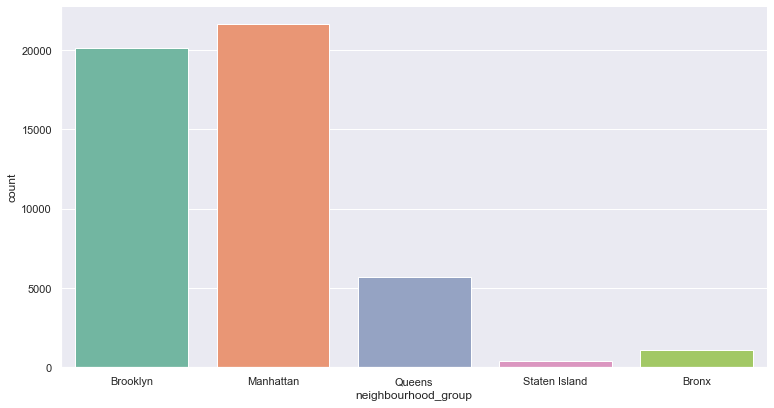

In [47]:
sns.set()
sns.catplot(x='neighbourhood_group', kind='count' ,data=df1_filtered,  palette="Set2")
plt.gcf().set_size_inches(12,6)
plt.show()

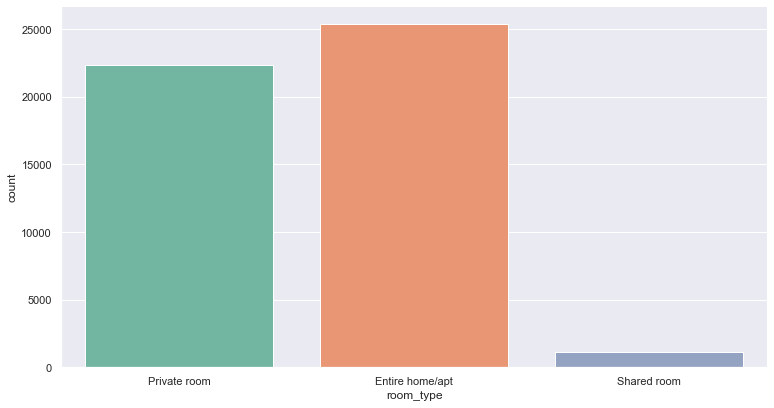

In [48]:
sns.set()
sns.catplot(x='room_type', kind='count' ,data=df1_filtered,  palette="Set2")
plt.gcf().set_size_inches(12,6)
plt.show()

### Correlation Plot

In [15]:
df1_filtered_corr_plot = df1_filtered.drop(columns=['id','host_id','neighbourhood', 'latitude','longitude'])

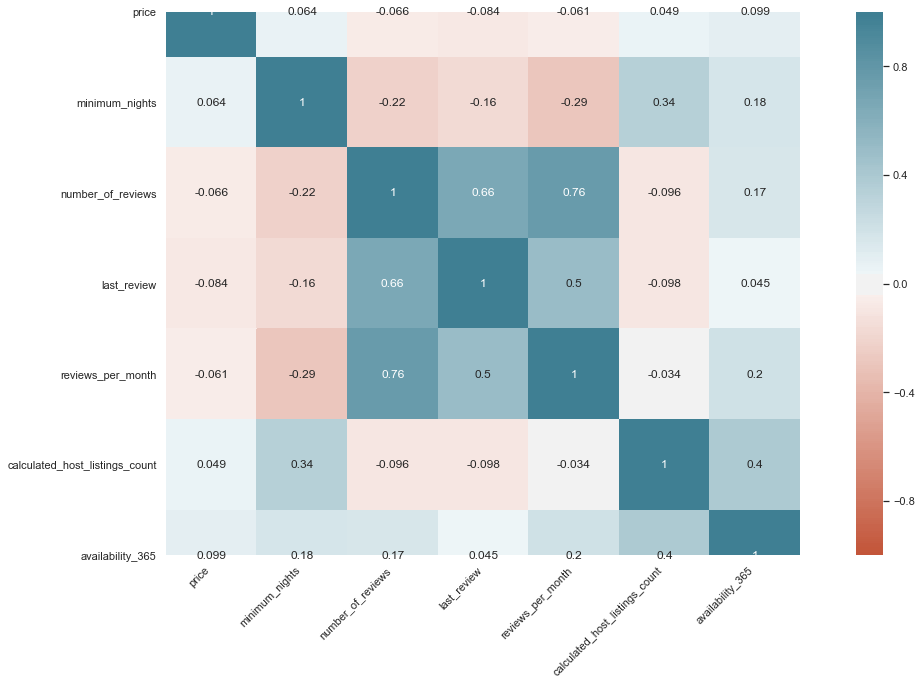

In [63]:
sns.set()
corr = df1_filtered_corr_plot.corr()
f, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot= True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# plt.figure(figsize=(30,20))
plt.show()

Green means positive, red means negative. Over here it seems that there reviews_per_month and number_of_reviews are correlated and reviews_per_month and last_reviews

### Feature Engineering

In [19]:
## Question: do we want to change availibity_365 to categorical? 
## e.g. --> if x > 300, 1 else 0

In [20]:
df1_filtered.dtypes

id                                  int64
host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                    float64
number_of_reviews                 float64
last_review                       float64
reviews_per_month                 float64
calculated_host_listings_count    float64
availability_365                    int64
dtype: object

In [21]:
df1_filtered.drop(columns=['id','host_id','latitude','longitude'], inplace= True)

In [22]:
df1_filtered.head(3)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,5.010635,0.693147,2.302585,7.924072,0.190620,1.945910,365
1,Manhattan,Midtown,Entire home/apt,5.420535,0.693147,3.828641,7.998671,0.322083,1.098612,355
2,Manhattan,Harlem,Private room,5.017280,1.386294,0.000000,0.000000,0.000000,0.693147,365


In [23]:
neighbourhood_encoding = pd.get_dummies(df1_filtered.neighbourhood)
room_type_encoding = pd.get_dummies(df1_filtered.room_type)

##### Convert categorical variables into dummy variables as it will help with the linear regression and random forests

In [24]:
df1_output = df1_filtered.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type']) 
df1_output = pd.concat((df1_output, neighbourhood_encoding), axis=1)
df1_output = pd.concat((df1_output, room_type_encoding), axis =1)

In [25]:
# df1_output.to_csv("new_york_data_cleaned_v1.csv", index=False)

In [26]:
df1_output.isna().sum()

price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Allerton                          0
Arden Heights                     0
Arrochar                          0
Arverne                           0
Astoria                           0
Bath Beach                        0
Battery Park City                 0
Bay Ridge                         0
Bay Terrace                       0
Bay Terrace, Staten Island        0
Baychester                        0
Bayside                           0
Bayswater                         0
Bedford-Stuyvesant                0
Belle Harbor                      0
Bellerose                         0
Belmont                           0
Bensonhurst                       0
Bergen Beach                      0
Boerum Hill                       0
Borough Park                

In [27]:
df1_output.head()

,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Allerton,Arden Heights,Arrochar,...,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside,Entire home/apt,Private room,Shared room
0,5.010635,0.693147,2.302585,7.924072,0.190620,1.945910,365,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5.420535,0.693147,3.828641,7.998671,0.322083,1.098612,355,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5.017280,1.386294,0.000000,0.000000,0.000000,0.693147,365,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4.499810,0.693147,5.602119,8.013674,1.729884,0.693147,194,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4.394449,2.397895,2.302585,7.935230,0.095310,0.693147,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
